# `Neural-Prophet` Machine Learning Model Documentation



# **Neural Prophet Parameters**
### ******Input Parameters from Interface******

#### NeuralProphet Parameters Description

Here's a detailed description of the parameters for the NeuralProphet time series forecasting model:

1. **Growth Parameters:**
   - `growth`: Determines the trend growth type. Options are 'off' (no trend), 'linear' (linear growth), 'discontinuous' (discontinuous growth).

2. **Changepoints Parameters:**
   - `changepoints`: List of specific dates to include as potential changepoints.
   - `n_changepoints`: Number of potential changepoints to automatically select.
   - `changepoints_range`: Proportion of history in which to select potential changepoints.

3. **Seasonality Parameters:**
   - `yearly_seasonality`: Automatically include yearly seasonality (set to 'auto' for automatic detection).
   - `weekly_seasonality`: Automatically include weekly seasonality.
   - `daily_seasonality`: Automatically include daily seasonality.
   - `seasonality_mode`: Type of seasonality, either 'additive' or 'multiplicative'.
   - `seasonality_reg`: Regularization term for seasonality.

4. **Confidence Interval Parameters:**
   - `confidence_lv`: Confidence level for prediction intervals.
   - `quantiles`: List of quantiles for prediction intervals.

5. **Missing Data Handling:**
   - `impute_missing`: Whether to impute missing values.
   - `impute_linear`: Number of data points to impute using linear interpolation.
   - `impute_rolling`: Number of data points to impute using rolling window mean.
   - `drop_missing`: Whether to drop missing values.

6. **Normalization Parameters:**
   - `normalize`: Type of normalization to apply ('auto', 'soft', 'soft1', 'minmax', 'standardize', 'off').

7. **Lags and Forecasts:**
   - `n_lags`: Number of lagged observations to include.
   - `n_forecasts`: Number of steps ahead to forecast.

8. **Autoregression Parameters:**
   - `ar_layers`: List of autoregressive layers.
   - `ar_reg`: Regularization term for autoregressive layers.
   - `lagged_reg_layers`: List of layers for lagged regularization.

9. **Training Parameters:**
   - `learning_rate`: Learning rate for model training.
   - `epochs`: Number of training epochs.
   - `batch_size`: Batch size for training.
   - `loss_func`: Loss function for training.
   - `optimizer`: Optimizer for training.

10. **Global/Local Parameters:**
    - `season_global_local`: Type of seasonality ('global' or 'local').
    - `trend_global_local`: Type of trend ('global' or 'local').

11. **Trend Parameters:**
    - `trend_reg`: Regularization term for the trend.
    - `trend_reg_threshold`: Threshold for trend regularization.
    - `newer_samples_weight`: Weight for newer samples in the trend.
    - `newer_samples_start`: Starting point for applying newer samples weight.

12. **Additional Configuration:**
    - `collect_metrics`: Specify whether to collect metrics during training.
    - `global_normalization`: Type of global normalization.
    - `global_time_normalization`: Type of global time normalization.
    - `unknown_data_normalization`: Type of normalization for unknown data.
    - `accelerator`: Acceleration type for training.
    - `trainer_config`: Configuration for the trainer.
    - `prediction_frequency`: Frequency of predictions during training.
	

In [2]:
#NeuralProphet

#Excel file Path
file_path= '/home/ajaz/DemandForecasting/Data/sampledata.csv'    
 
#1. **Growth Parameters:**
growth='off'  #Literal['off', 'linear', 'discontinuous']

#2. **Changepoints Parameters:**
changepoints= None #Optional[list]
n_changepoints =None    #0, #int
changepoints_range=None     #0.8 #float

#3. **Seasonality Parameters:**
#To Control Seasonality
yearly_seasonality= None  #'auto'ss
weekly_seasonality= None   #'auto'
daily_seasonality = None   #'auto'

seasonality_mode='multiplicative' #['additive', 'multiplicative']
seasonality_reg= None    #float 0

#4. **Confidence Interval Parameters:**
confidence_lv = 0.9
#quantiles  = None      #[]   #List[float]
quantiles = [round(((1 - confidence_lv) / 2), 2), round((confidence_lv + (1 - confidence_lv) / 2), 2)]

#5. **Missing Data Handling:**
impute_missing= None,     #bool
impute_linear = None,    #int
impute_rolling= None,  #int
drop_missing  = None   #bool

#6. **Normalization Parameters:**
normalize=None         #'off'       # Literal['auto', 'soft', 'soft1', 'minmax', 'standardize', 'off']

#7. **Lags and Forecasts:**
n_lags=None        #0    # int 0
n_forecasts=None   #0 #int 1

#8. **Autoregression Parameters:**
ar_layers=None     #[]    #Optional[list]
ar_reg= None       #Optional[float]
lagged_reg_layers= None    #[]   #Optional[list]
learning_rate= 0.1   #Optional[float]

#9. **Training Parameters:**
epochs= None      #Optional[int]
batch_size= None   #Optional[int]
loss_func=None     #'Huber'
optimizer=None     #'AdamW'

#10. **Global/Local Parameters:**
season_global_local=None #['global', 'local']
trend_global_local= None   #str 'global', 'local'

#11. **Trend Parameters:**
trend_reg= None  #Optional[float]
trend_reg_threshold =None  #Optional[Union[bool, float]]
newer_samples_weight= None  # float
newer_samples_start =None   #float

#12. **Additional Configuration:**
collect_metrics= None      #Union [bool, list, dict]

global_normalization=None
global_time_normalization=None
unknown_data_normalization=None

accelerator=None  #Optional[str] None
trainer_config=None # dict {},
prediction_frequency=None  # Optional[dict]

# Additional Seasonality Regressors Parameters Description

Here's a detailed description of the parameters related to additional seasonality regressors, including custom holidays:

1. **Custom Holidays:**
   - `country_name`: Country code (ISO 3166-2) for custom holidays.

2. **Yearly Seasonality Parameters:**
   - `yearly_add_seasonality`: Whether to include yearly seasonality.
   - `yearly_season_period`: Length of the yearly season in days.
   - `yearly_season_fourier_order`: Number of Fourier series components for modeling yearly seasonality.

****Similarly for the below seasonalities:****

3. **Quarterly Seasonality Parameters:**
4. **Monthly Seasonality Parameters:**
5. **Weekend Seasonality Parameters:**
6. **Working Days Seasonality Parameters:**
7. **Ramadan Seasonality Parameters:**

In [3]:
#Additional  Seasonality regressors

#Custom holidays
country_name= 'SA'   #   'SA' # Country Code  (ISO 3166-2) for holidayss

yearly_add_seasonality=True
yearly_season_period=365.25
yearly_season_fourier_order=2

quarterly_add_seasonality=False
quarterly_season_period=None
quarterly_season_fourier_order=None

monthly_add_seasonality=False
monthly_season_period=None
monthly_season_fourier_order=None

# Weekend days (0-6, Mon-Sun)
weekend_days = [4]  # 4 is Friday

Weekend_add_seasonality=False
weekendDaysCount=1
Weekends_fourier_order=5

WorkingDays_add_seasonality=False
workingDaysCount=6
WorkingDays_fourier_order=5

ramadan_add_seasonality=False
ramadan_period=29.33
ramadan_fourier_order=10

#### ******Parameters used in other calc, other than the model******


In [4]:
# Penalty sensitivity for PELT algorithm: 'High', 'Medium', 'Low' : Used to determine the penalty value for the PELT algo which is used for changepoint detection
PenaltySensitivity ="High"  

# Model type for changepoint detection: 'l1' (linear 1), 'l2' (linear 2), 'rbf' (radial basis function)
pltModelType = "l2"  # "l2", "rbf"

detectoutliers =False # If True, outliers are detected and removed from the data else outliers are not detected and not removed from the data

#IQR stands for Interquartile Range, which is a measure of statistical dispersion of data
#IQR Range for outlier detection (1.5 is default) 3 is too high ,  upper_bound = Q3 + IQRRange * IQR and lower_bound = Q1 - IQRRange * IQR 

IQRRange=1.5

# ****Prophet Algorithm****

### ****Importing Libraries****

In [1]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import numpy as np

import logging
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math
import ruptures as rpt
import warnings
import holidays
from hijri_converter import convert
from datetime import date,datetime, timedelta
from prophet.diagnostics import performance_metrics, cross_validation
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

warnings.filterwarnings("ignore")

### ****Importing the dataset****

#### ****Method to Import Excel and CSV File****

In [18]:
#Reading the file , checking if it is a CSV or Excel file, checking if it is empty, checking if it has required columns
#Returns a DataFrame with only the required columns
#User can input a path to a CSV or Excel file
#Mandatory columns: date, value
#Will Generalize in the future to accept more columns and to accept more file types and to accept more data sources

def loadCsvExcelFile(file_path):
    while True:
        try:
            # Read file path from the user
            file_path=file_path
            #file_path = input("Enter the path of the Excel or CSV file: ")

            # Try to import the file as a DataFrame
            try:
                if file_path.lower().endswith('.csv'):
                    df = pd.read_csv(file_path)
                elif file_path.lower().endswith(('.xls', '.xlsx')):
                    df = pd.read_excel(file_path)
                else:
                    raise ValueError("Unsupported file format. Please provide a CSV or Excel file.")
            except pd.errors.EmptyDataError:
                raise ValueError("The file is empty.")

            # Check if DataFrame has required columns
            if 'date' not in df.columns or 'value' not in df.columns:
                raise ValueError("The DataFrame must have columns named 'date' and 'value'.")

            # Return the resulting DataFrame
            return df[['date', 'value']]

        except FileNotFoundError:
            print("Error: File not found. Please provide a valid file path.")
        except pd.errors.ParserError:
            raise ValueError("Error reading the file. Please check if it is a valid CSV or Excel file.")
        except Exception as e:
            print(f"Error: {e}")
            retry = input("Do you want to try again? (y/n): ").lower()
            if retry != 'y':
                break

### Read the Excel File

In [19]:
# Example usage
try:
    result_df = loadCsvExcelFile (file_path)
    print('Sucessfully read the file')
except ValueError as ve:
    print('Un Sucessfull in reading the file')
    print(ve)

Sucessfully read the file


In [10]:
data = result_df.copy()
data = data.rename(columns={'date': 'ds', 'value': 'y'})  # Rename columns for Prophet compatibility
data['ds'] = pd.to_datetime(data['ds'])  # Convert to datetime

#### Old Method to Read the excel file

In [14]:
""" # Load and prepare the data for Prophet
df = pd.read_csv('/home/ajaz/DemandForecasting/Data/data.csv')
data = df.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'y'})  # Rename columns for Prophet compatibility
data = data[['ds', 'y']]
data['ds']=pd.to_datetime(data['ds'])

#Copy the dataframe data
data_copy = data.copy()
""" 

# # Define the start and end dates for filtering covid  
covid_start_date = '2020-03-02'
covid_end_date = '2020-06-21'

# Filter the data frame to include only the year 2023
#data = data[data['ds'].dt.year ==2023]

# Get the first and last dates of the filtered data
start_date = pd.to_datetime( data['ds'].iloc[0])
end_date = pd.to_datetime( data['ds'].iloc[-1])

# Extract the first 30 days of the data
first_30Days = data.iloc[0:30]

data.head(2)
#plt = data.plot(x="ds", y="y", figsize=(15, 5))

,ds,y
0,2018-01-01,50930.49
1,2018-01-02,73204.65


## Detecting Growth Param: detectGrowth

In [20]:
def detectGrowth(data, threshold=0.5, window_size=7):
    """
    Detects the growth type based on the rolling mean trend of a given dataset.

    Parameters:
    - data: DataFrame, the input data.
    - threshold: float, a threshold to categorize the growth type.
    - window_size: int, the window size for calculating the rolling mean.

    Returns:
    - str, the detected growth type.
    """

    # Make a copy of the data
    growth_df = data.copy()

    # Calculate the rolling mean with a specified window size
    growth_df['rolling_mean'] = growth_df['y'].rolling(window=window_size).mean()

    # Determine growth type based on the rolling mean trend
    mean_diff = growth_df['rolling_mean'].diff().mean()

    # Categorize the growth type
    if abs(mean_diff) < threshold:
        growth = 'flat'
    elif mean_diff != 0:
        growth = 'linear'
    else:
        growth = 'discontinuous'

    # Return the detected growth type
    return growth

In [23]:
# Example usage:
growth = detectGrowth(data)
print(f"The growth type is '{growth}'.")
growth

The growth type is 'linear'.


'linear'

In [ ]:
""" 
growth_df=data.copy()
#copy the data dataframe to growth_df

# Set a suitable threshold based on the characteristics of your data
threshold = 0.5  # You may need to adjust this based on your specific use case 

# Calculate the rolling mean with a window size (adjust as needed)
window_size = 7
growth_df['rolling_mean'] = growth_df['y'].rolling(window=window_size).mean()

# Determine growth type based on the rolling mean trend
mean_diff = growth_df['rolling_mean'].diff().mean()

# Categorize the growth type
if abs(mean_diff) < threshold:
    growth = 'flat'
elif mean_diff != 0:
    growth = 'linear'
else:
    growth = 'discontinuous' 
# Print the result
print(f"The growth type is '{growth}'.")


# Plot the time series data and rolling mean
plt.figure(figsize=(15, 6))
plt.plot(growth_df['ds'], growth_df['y'], label='Original Data')
plt.plot(growth_df['ds'], growth_df['rolling_mean'], label=f'Rolling Mean (window={window_size})', color='orange')
plt.title('Time Series Data and Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show() """

## Detecting Change points Parameter using ****PELT**** Algo

### Old Method

PELT algorithm is utilized for changepoint detection in the trained data

,ds,y
0,2018-01-01,50930.49
1,2018-01-02,73204.65


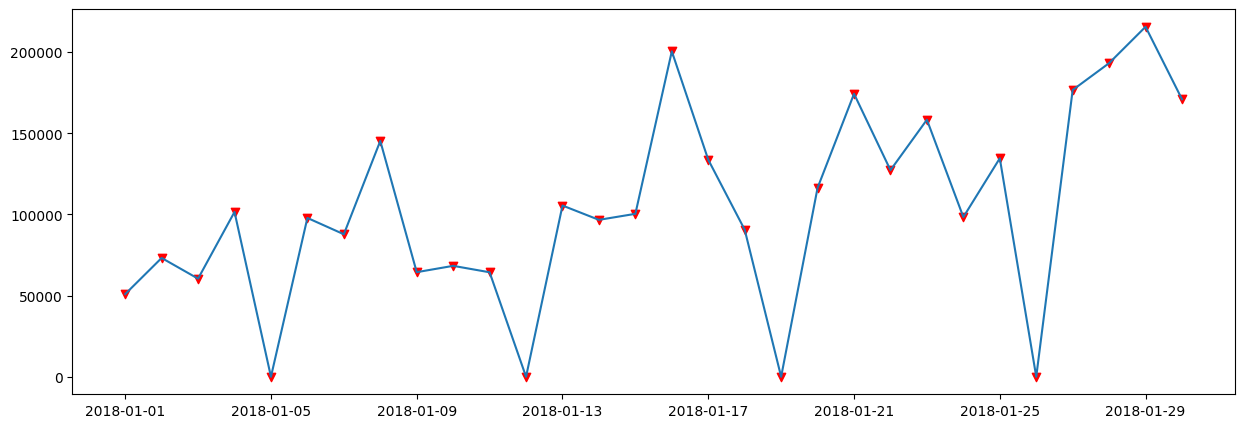

In [26]:
# Define a function to calculate the penalty for changepoint detection based on sensitivity level and predefined coefficients

def calculate_penalty(data, sensitivity, cal=[6, 3, 1.5]):
    if sensitivity == "Low":
        return cal[0] * math.log(len(data))
    elif sensitivity == "Medium":
        return cal[1] * math.log(len(data))
    elif sensitivity == "High":
        return cal[2] * math.log(len(data))

peltdata = data['y'].values

# You can choose between "l1" and "l2" cost functions
algo = rpt.Pelt(model=pltModelType, min_size=1, jump=1).fit(peltdata)
penalty= calculate_penalty(peltdata, PenaltySensitivity)
result = algo.predict(pen=3)

changepointDates=[]
for index in result:
    a=data.iloc[index-1]['ds']
    changepointDates.append(a)

changepointDates=pd.DataFrame(changepointDates, columns=['ds'])
changepointDates['ds'] = pd.to_datetime(changepointDates['ds'])
changepoints=changepointDates['ds']

# Plot the changepoints on the time series data

daysInChangepoints=first_30Days.loc[first_30Days['ds'].isin(changepoints)]

plt.plot(first_30Days['ds'],first_30Days['y'] )
plt.scatter(daysInChangepoints['ds'],daysInChangepoints['y'], marker='v', color='r')
fig = plt.gcf()
fig.set_size_inches(15, 5)

daysInChangepoints.head(2)
#holidays=holidays
#changepointDates.head(2) 

In [25]:
changepoints

0      2018-01-01
1      2018-01-02
2      2018-01-03
3      2018-01-04
4      2018-01-05
          ...    
1981   2023-07-27
1982   2023-07-28
1983   2023-07-29
1984   2023-07-30
1985   2023-07-31
Name: ds, Length: 1986, dtype: datetime64[ns]

In [ ]:
# Plot the changepoints on the time series data

daysInChangepoints=first_30Days.loc[first_30Days['ds'].isin(changepoints)]

plt.plot(first_30Days['ds'],first_30Days['y'] )
plt.scatter(daysInChangepoints['ds'],daysInChangepoints['y'], marker='v', color='r')
fig = plt.gcf()
fig.set_size_inches(15, 5)

daysInChangepoints.head(2)
#holidays=holidays
#changepointDates.head(2) 

## Generate Ramadan Dates

The function generate_ramadan_dates_df(start_year, end_year) generates a DataFrame of Ramadan dates in the Gregorian calendar for a given range of years.

In [17]:
def generate_ramadan_dates_df(start_year, end_year):
    ramadan_dates = []

    for year in range(start_year, end_year + 1):
        # The Umm al-Qura calendar uses Hijri dates for Islamic months
        hijri_year_start = convert.Gregorian(year, 1, 1).to_hijri()
        hijri_year_end = convert.Gregorian(year, 12, 30).to_hijri()

        for day in range(1, 30):  # Assuming Ramadan lasts for 29 or 30 days
            # Find the date of Ramadan in the Hijri calendar
            ramadan_date = convert.Hijri(hijri_year_start.year, 9, day).to_gregorian()

            # Append the date to the list
            ramadan_dates.append(ramadan_date)

    # Create a DataFrame with a column named 'ramadan_dates'
    ramadan_df = pd.DataFrame({'ds': ramadan_dates})
    return ramadan_df

start_year = start_date.year
end_year = end_date.year
ramadan_df = generate_ramadan_dates_df(start_year, end_year)

#### Adding  Ramadan dates in prophet Training Data
if ramadan_add_seasonality:
    data['is_ramadan'] = data['ds'].isin(ramadan_df['ds']).astype(int)
    data.head(2)

## Generate the Weekend Days Param

In [16]:
def generate_weekends(start_date, end_date, weekend_days):
    '''
    This function will generate weekends dataframe with ds and holiday columns
    Parameters : 
    start_date : start date of the data of type datetime
    end_date : end date of the data of type datetime
    weekend_days : list of weekend days ex: [4] for Friday
    return : weekends dataframe with ds and holiday columns
    '''
    weekends = []
    current_date = start_date
    while current_date <= end_date:
        # Check if the current date is a weekend
        if current_date.weekday() in weekend_days:
            weekends.append(current_date)
        current_date += timedelta(days=1)

    # Create a DataFrame with day names and dates
    weekend_df = {'ds': weekends,
                  'holiday': [day.strftime('%A') for day in weekends]}

    df_weekends = pd.DataFrame(weekend_df)
    return df_weekends
#print(type(start_date))
df_weekends = generate_weekends(start_date, end_date, weekend_days)
if Weekend_add_seasonality:
    data['is_weekend'] = data['ds'].isin(df_weekends['ds']).astype(int)  
if WorkingDays_add_seasonality:
    data['is_weekday'] = (data['is_weekend'] == 0).astype(int)
data.head(2)

,ds,y
0,2018-01-01,50930.49
1,2018-01-02,73204.65


In [ ]:
if Weekend_add_seasonality:
    weekendDaysCount= len(weekend_days)
    workingDaysCount= 7 - weekendDaysCount

    first_30Days['is_weekend'] = first_30Days['ds'].isin(df_weekends['ds']).astype(int)
    onlyWeekends= first_30Days[data['is_weekend']==1]

    plt.plot(first_30Days['ds'],first_30Days['y'])
    plt.scatter(onlyWeekends['ds'],onlyWeekends['y'], marker='v', color='r')
    #increase the width of the plot
    fig = plt.gcf()
    fig.set_size_inches(15, 5)
if ramadan_add_seasonality:
    data['is_ramadan'] = data['ds'].isin(ramadan_df['ds']).astype(int)

# Outlier
##### Original Data Filtered by the Outliers

In [ ]:
if detectoutliers:
    #plot like a fot not as a line for data['ds'], data['y']  ds on x axis and y on y axis, dont join the line only the points
    plt.scatter(data['ds'], data['y'], linestyle = 'solid',color='red')
    #increase the width of the plot
    fig = plt.gcf()
    fig.set_size_inches(15, 5)

    print(data['y'].describe())
    Q1 = data['y'].quantile(0.25)
    Q3 = data['y'].quantile(0.75)
    QCustom99= data['y'].quantile(0.99)

    IQR = Q3 - Q1

    lower_bound = Q1 - IQRRange * IQR
    upper_bound = Q3 + IQRRange * IQR
    soutliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

    # Identifying outliers
    outliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

    # Replace outlier values with the mean
    data.loc[outliers.index, 'y'] = data['y'].mean()


    plt.scatter(data['ds'], data['y'], linestyle = 'solid',color='green')
    #plt.scatter(data['ds'], data['y'], linestyle = 'solid',color='red')


    print('CustomQuartile99 < 99% : ' + str(QCustom99))
    print('IQR : ' + str(IQR))

    print('Number of Outliers :' + str(len(soutliers)))
    print('Number of rows in data : ' + str(len(data)))
    print('lower_bound : ' + str(lower_bound))
    print('upper_bound : ' + str(upper_bound))
    print(outliers)

# Create a Prophet model with flexible parameters

In [ ]:
neuralprophet_params = {
'growth':growth,
#'changepoints':changepoints,
'n_changepoints':n_changepoints,
'changepoints_range':changepoints_range,

'yearly_seasonality':yearly_seasonality,
'weekly_seasonality':weekly_seasonality,
'daily_seasonality':daily_seasonality,

'seasonality_mode':seasonality_mode,
'seasonality_reg':seasonality_reg,

'quantiles':quantiles,

'impute_missing':impute_missing,
'impute_linear':impute_linear,
'impute_rolling':impute_rolling,
'drop_missing':drop_missing,
'normalize':normalize,

'n_lags':n_lags,
'n_forecasts':n_forecasts,

'ar_layers':ar_layers,
'ar_reg':ar_reg,
'lagged_reg_layers':lagged_reg_layers,
'learning_rate':learning_rate,

'epochs':epochs,
'batch_size':batch_size,
'loss_func':loss_func,
'optimizer':optimizer,

'season_global_local':season_global_local,

'trend_reg':trend_reg,
'trend_reg_threshold':trend_reg_threshold,
'trend_global_local':trend_global_local,

'newer_samples_weight':newer_samples_weight,
'newer_samples_start':newer_samples_start,

'collect_metrics':collect_metrics,

'global_normalization':global_normalization,
'global_time_normalization':global_time_normalization,
'unknown_data_normalization':unknown_data_normalization,

'accelerator':accelerator,
'trainer_config':trainer_config,
'prediction_frequency':prediction_frequency

}
print(neuralprophet_params)
# Remove parameters with value None
neuralprophet_params = {key: value for key, value in neuralprophet_params.items() if value is not None}
print(neuralprophet_params)

# **Training Model**

#### ****Initialize the Model**** ####

In [ ]:
print(neuralprophet_params)

In [ ]:
model = NeuralProphet (**neuralprophet_params)

In [ ]:
data.head(2)

### ****Custom  Seasonalties****

In [ ]:
#Custom seasonality
#if the  passed condition is True or Not none then it  execute the below code
#Check the names of the variables from the variables

if country_name:
    model.add_country_holidays(country_name=country_name)

if yearly_add_seasonality:
    model.add_seasonality(name='yearly_season' ,period=yearly_season_period ,fourier_order=yearly_season_fourier_order )

if quarterly_add_seasonality:
    model.add_seasonality(name='quarterly_season' ,period=quarterly_season_period ,fourier_order=quarterly_season_fourier_order )

if monthly_add_seasonality:
    model.add_seasonality(name='monthly_season' ,period=monthly_season_period ,fourier_order=monthly_season_fourier_order )

if Weekend_add_seasonality:
    model.add_seasonality(name='Weekends_season' ,period=weekendDaysCount ,fourier_order=Weekends_fourier_order ,condition_name="is_weekend")

if WorkingDays_add_seasonality:
    model.add_seasonality(name='WorkingDays_season' ,period=workingDaysCount ,fourier_order=WorkingDays_fourier_order ,condition_name="is_weekday")

if ramadan_add_seasonality:
    model.add_seasonality(name='ramadan_season' ,period=ramadan_period ,fourier_order=ramadan_fourier_order ,condition_name="is_ramadan")

#### ****Fit the model to the data**** ####

In [ ]:
# Use static plotly in notebooks
model.set_plotting_backend("plotly-static")
model.fit(data)

## Generate future Dataframe Dates

In [ ]:
# Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
df_future = model.make_future_dataframe(data, n_historic_predictions=True, periods=30)
 # Predict the future
forecast = model.predict(df_future)

In [ ]:
# Visualize the forecast
model.plot(forecast)

In [ ]:
model.plot_components(forecast)

In [ ]:
model.plot_parameters()

In [ ]:
model.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast)

In [ ]:
#last 30 days of the forecast
forecast.tail(2)

### Comparision of actual data and forecasted data

In [ ]:
actualdata = pd.read_csv('/home/ajaz/DemandForecasting/Data/actualdata.csv')

In [ ]:
actualdata = actualdata.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'actual'})
#Convert a dataframe column to date only
actualdata['ds']=pd.to_datetime(actualdata['ds']) 
forecast = forecast[['ds','yhat1']].tail(30)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(forecast['ds'], forecast['yhat1'], label='forecast')
ax.plot(actualdata['ds'], actualdata['actual'], label='actual')
ax.legend(loc='upper left')

plt.show()

## Validation and Reproducibility

In [ ]:
df = data.copy()
df_train, df_test = model.split_df(df=df, freq="D", valid_p=0.2)
# Split the dataset into training and validation sets
forecast_test = model.predict(df=df_test)
metrics_test = model.test(df=df_test)
metrics_test[['MAE_val']]